In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import pandas as pd

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import r2_score
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn import grid_search
import requests
import json
from category import Category
from database import Database
from playlist import Playlist
from track import Track
from artist import Artist
from genre import Genre

from collections import Counter
from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Data Import And Processing

In [2]:
# Connect to database and load all playlist data
db = Database()
genresByPopularity = list(Genre.getByPopularity(db))
playlists = Playlist.loadAll(db)


In [7]:
# Get a list of all genres for all artists, frequency in the list
# indicates how many times those genres appear
def getAllGenres():
    genres = []
    for playlist in playlists:
        for track in playlist.tracks:
            if track.artist1:
                genres.extend(track.artist1.genres)
            if track.artist2:
                genres.extend(track.artist2.genres)
            if track.artist3:
                genres.extend(track.artist3.genres)
    return genres

# Remove all playlists containing "This is:" indicating that it features
# a single artist
def filterAllSingleArtist(playlists):
    multiArtistPlaylists = []
    for playlist in playlists:
        if 'this is:' not in playlist.name.decode('UTF-8').lower():
            multiArtistPlaylists.append(playlist)
    return multiArtistPlaylists

# Get a list of unique genres, sorted by their frequency
def genresByCount(allGenres):
    genresCount = Counter(allGenres)
    genresList = list(genresCount.items())
    # Sort the genres list by frequency
    genresList.sort(key=lambda x: -x[1])
    genres = [genre[0] for genre in genresList]
    # An empty string has been creeping into here
    if '' in genres:
        genres.remove('')
    return genres

# Get a list of all genres by frequency
genres = genresByCount(getAllGenres())
# Filter out single artist playlists
playlists = filterAllSingleArtist(playlists)
# Should have 1423 playlists
print(len(playlists))

1423


In [8]:
# For an arbitrary list of genres, remove empty strings and sort by frequency
def cleanGenres(artistGenres, limit=None):
    artistGenres = list(set(artistGenres))
    if '' in artistGenres:
        artistGenres.remove('')
    artistGenres.sort(key=lambda x: genres.index(x))
    if limit:
        return artistGenres[:limit]
    return artistGenres

# Test the genre cleaner
# should print ['pop', 'rock', 'jazz', 'deep dutch hip hop']
print(cleanGenres(['deep dutch hip hop', 'pop', '', 'jazz', '', 'rock']))
# should print ['pop', 'rock']
print(cleanGenres(['deep dutch hip hop', 'pop', '', 'jazz', '', 'rock'], 2))

['pop', 'rock', 'jazz', 'deep dutch hip hop']
['pop', 'rock']


In [9]:
# Clean all of the genres for all artist objects
for playlist in playlists:
    for track in playlist.tracks:
        if track.artist1:
            track.artist1.genres = cleanGenres(track.artist1.genres)
        if track.artist2:
            track.artist2.genres = cleanGenres(track.artist2.genres)
        if track.artist3:
            track.artist3.genres = cleanGenres(track.artist3.genres)

In [10]:
# Function to find a "most representative" genre for each playlist
# Uses some number of most popular genres per artist, limits the return
# to the most popular
def getPlaylistGenres(playlist, numPerArtist=1, limit=2):
    playlistGenres = []
    for track in playlist.tracks:
        if track.artist1:
            playlistGenres.extend(track.artist1.genres[:numPerArtist])
        if track.artist2:
            playlistGenres.extend(track.artist2.genres[:numPerArtist])
        if track.artist3:
            playlistGenres.extend(track.artist3.genres[:numPerArtist])
    
    playlistGenres = genresByCount(playlistGenres)[:limit]
    return playlistGenres


['edm']


In [34]:
# Get both the single "main genre" and a list of most relevant genres per playlist
for playlist in playlists:
    playlist.mainGenre = getPlaylistGenres(playlist, 2, 1)[0]
for playlist in playlists:
    playlist.genres = getPlaylistGenres(playlist, 2, 4)

8


In [14]:
# Create DataFrame with playlist properties

In [37]:
# numTracks
# meanTrackPopularities
# sdTrackPopularities
# meanArtistPopularities
# sdArtistPopularities
# meanArtistFollowers
# sdArtistFollowers
# meanArtistViews
# sdArtistViews
# followers
def flattenPlaylist(playlist, get_raw=False):
    trackPopularities = []
    artistPopularities = []
    artistFollowers = []
    artistViews = []
    explicit = []
    trackDurations = []
    for track in playlist.tracks:
        explicit.append(track.explicit)
        trackDurations.append(track.duration)
        trackPopularities.append(track.popularity)
        if track.artist1:
            artistPopularities.append(track.artist1.popularity)
            artistFollowers.append(track.artist1.followers)
            artistViews.append(track.artist1.views)
        if track.artist2:
            artistPopularities.append(track.artist2.popularity)
            artistFollowers.append(track.artist2.followers)
            artistViews.append(track.artist2.views)
        if track.artist3:
            artistPopularities.append(track.artist3.popularity)
            artistFollowers.append(track.artist3.followers)
            artistViews.append(track.artist3.views)
    
    if get_raw:
        return {'num_tracks': len(playlist.tracks), 'explicit': explicit, 'track_durations': trackDurations, 'track_popularities': trackPopularities, 'artist_popularities': artistPopularities, 'artist_followers': artistFollowers, 'artist_views': artistViews, 'playlist_followers': playlist.followers}

    else:
        return [len(playlist.tracks), np.mean(explicit), np.mean(trackDurations), np.mean(trackPopularities), np.std(trackPopularities), np.max(trackPopularities), np.mean(artistPopularities), np.std(artistPopularities), np.max(artistPopularities), np.mean(artistFollowers), np.std(artistFollowers), np.max(artistFollowers), np.mean(artistViews), np.std(artistViews), np.max(artistViews), playlist.followers]
    
headers = ['num_tracks', 'mean_track_explicit', 'mean_track_popularities', 'mean_track_duration', 'std_track_popularities', 'max_track_popularities', 'mean_artist_popularities', 'std_artist_popularities', 'max_artist_popularities','mean_artist_followers', 'std_artist_followers', 'max_artist_followers', 'mean_artist_views', 'std_artist_views', 'max_artist_views', 'followers']

flattened = [flattenPlaylist(playlist) for playlist in playlists]
df = pd.DataFrame(flattened, columns=headers)

msk = np.random.rand(len(df)) < 0.75
data_train = df[msk]
data_test = df[~msk]

ytrain = data_train.iloc[:,-1]
Xtrain = data_train.drop(data_test.columns[len(data_test.columns)-1], axis=1)

ytest = data_test.iloc[:,-1]
Xtest = data_test.drop(data_test.columns[len(data_test.columns)-1], axis=1)

In [38]:
data_train.head()

,num_tracks,mean_track_explicit,mean_track_popularities,mean_track_duration,std_track_popularities,max_track_popularities,mean_artist_popularities,std_artist_popularities,max_artist_popularities,mean_artist_followers,std_artist_followers,max_artist_followers,mean_artist_views,std_artist_views,max_artist_views,followers
0,22,0.090909,227756.227273,42.590909,19.106541,67,61.848485,16.507338,89,5.641147e+05,1.215937e+06,5210412,6.641898e+05,9.247158e+05,4443917,16084
1,60,0.000000,276171.466667,14.683333,9.319320,43,50.064516,15.590393,84,2.297654e+05,6.352567e+05,4424637,8.149162e+05,2.916046e+06,23129006,17864
2,100,0.070000,210771.360000,46.430000,12.488599,76,53.240385,13.572098,78,9.389038e+04,1.894456e+05,924636,1.175892e+05,2.852078e+05,2671926,256892
3,88,0.090909,217517.454545,53.329545,13.680379,76,64.408602,12.860907,100,3.087468e+05,5.616157e+05,3464127,3.340995e+05,7.646027e+05,5936516,668423
4,50,0.180000,247698.080000,66.880000,12.457351,81,77.320000,5.880272,91,1.728723e+06,1.431618e+06,6157956,1.716571e+06,1.831774e+06,8068727,944837


In [29]:
data_train.describe()

,num_tracks,mean_track_explicit,mean_track_popularities,mean_track_duration,std_track_popularities,max_track_popularities,mean_artist_popularities,std_artist_popularities,max_artist_popularities,mean_artist_followers,std_artist_followers,max_artist_followers,mean_artist_views,std_artist_views,max_artist_views,followers
count,1064.000000,1064.000000,1.064000e+03,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,1.064000e+03,1.064000e+03,1.064000e+03,1.064000e+03,1.064000e+03,1.064000e+03,1.064000e+03
mean,52.489662,0.096096,2.627746e+05,38.558817,15.813818,66.781955,58.828321,13.096900,83.081767,8.184305e+05,1.133984e+06,5.343359e+06,1.192771e+06,1.639798e+06,7.575703e+06,2.070505e+05
std,25.779291,0.189624,1.762448e+05,16.925266,5.742346,18.145990,16.564837,4.728943,15.222028,1.054527e+06,1.230417e+06,5.375022e+06,1.334781e+06,1.426807e+06,6.101234e+06,5.383924e+05
min,6.000000,0.000000,3.962875e+04,0.000000,0.000000,0.000000,2.316832,0.000000,14.000000,1.120000e+02,0.000000e+00,1.120000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,30.000000,0.000000,2.145070e+05,27.242611,12.031631,59.000000,48.988095,10.290555,77.000000,8.517955e+04,1.722229e+05,9.024690e+05,2.170200e+05,4.487777e+05,2.410864e+06,1.021750e+03
50%,50.000000,0.013514,2.310108e+05,39.281387,16.527453,70.000000,60.015964,12.898099,86.000000,3.661759e+05,6.196038e+05,3.257736e+06,6.623496e+05,1.178286e+06,5.838257e+06,2.802500e+04
75%,69.000000,0.100000,2.528527e+05,50.113333,20.078235,78.000000,70.942718,15.710244,95.000000,1.124934e+06,1.671755e+06,9.080624e+06,1.766474e+06,2.585513e+06,1.227502e+07,1.706778e+05
max,100.000000,1.000000,2.507284e+06,90.300000,34.226306,100.000000,93.818182,37.446410,100.000000,6.050277e+06,5.189948e+06,1.538430e+07,1.410642e+07,5.930445e+06,2.312901e+07,1.108252e+07


In [56]:
# Build a dataframe with statistics for each genre
mainGenres = list(set([playlist.mainGenre for playlist in playlists]))

# Build a dictionary to get a set of playlists by their "mainGenre"
genresToPlaylists = defaultdict(list)
for playlist in playlists:
    genresToPlaylists[playlist.mainGenre].append(playlist)

df_rows = []
for genre, genrePlaylists in genresToPlaylists.items():
    playlistsData = []
    numTracks = []
    explicit = []
    trackDurations = []
    trackPopularities = []
    artistPopularities = []
    artistFollowers = []
    artistViews = []
    playlistFollowers = []
    for playlist in genrePlaylists:
        data = flattenPlaylist(playlist, True)
        numTracks.append(data['num_tracks'])
        explicit.extend(data['explicit'])
        trackDurations.extend(data['track_durations'])
        trackPopularities.extend(data['track_popularities'])
        artistPopularities.extend(data['artist_popularities'])
        artistFollowers.extend(data['artist_followers'])
        artistViews.extend(data['artist_views'])
        playlistFollowers.append(data['playlist_followers'])
    df_rows.append([genre, len(genrePlaylists), np.sum(numTracks), np.mean(numTracks), np.mean(explicit), np.mean(trackDurations), np.mean(trackPopularities), np.std(trackPopularities), np.max(trackPopularities), np.mean(artistPopularities), np.std(artistPopularities), np.max(artistPopularities), np.mean(artistFollowers), np.std(artistFollowers), np.max(artistFollowers), np.mean(artistViews), np.std(artistViews), np.max(artistViews), np.mean(playlistFollowers)])

headers = ['genre', 'num_playlists', 'num_tracks', 'mean_num_tracks', 'mean_track_explicit', 'mean_track_popularities', 'mean_track_duration', 'std_track_popularities', 'max_track_popularities', 'mean_artist_popularities', 'std_artist_popularities', 'max_artist_popularities','mean_artist_followers', 'std_artist_followers', 'max_artist_followers', 'mean_artist_views', 'std_artist_views', 'max_artist_views', 'followers']
df_genres = pd.DataFrame(df_rows, columns=headers)

In [57]:
df_genres.head()

,genre,num_playlists,num_tracks,mean_num_tracks,mean_track_explicit,mean_track_popularities,mean_track_duration,std_track_popularities,max_track_popularities,mean_artist_popularities,std_artist_popularities,max_artist_popularities,mean_artist_followers,std_artist_followers,max_artist_followers,mean_artist_views,std_artist_views,max_artist_views,followers
0,adult standards,18,662,36.777778,0.003021,188168.638973,30.463746,20.779181,84,54.297844,18.010822,97,263476.621294,6.275888e+05,7430477,1.092735e+06,2.110189e+06,14041072,51738.388889
1,folk-pop,80,4980,62.250000,0.012651,231950.842771,36.934940,20.903896,97,58.062476,15.569894,99,379653.359763,1.155905e+06,14120621,5.046639e+05,1.403732e+06,23129006,200714.587500
2,movie tunes,1,25,25.000000,0.000000,190702.320000,30.280000,19.564294,65,55.812500,18.288380,93,338013.468750,9.851293e+05,5391500,9.017510e+05,2.081898e+06,7986487,2502.000000
3,vocal jazz,3,103,34.333333,0.000000,287243.359223,41.456311,14.232996,71,52.258333,12.377059,86,129371.258333,3.934171e+05,3090044,4.551741e+05,1.003524e+06,6830283,184372.333333
4,indie pop,1,100,100.000000,0.020000,220538.090000,44.010000,16.680824,67,53.287129,10.331473,86,61271.267327,1.327780e+05,672387,1.321441e+05,3.643028e+05,2432600,900951.000000


# Exploratory Data Analysis

In [45]:
# Correlation heatmap
import seaborn as sns

#
#  We use Pandas' 'corr' method to compute pairwise correlation of column (defaults to Pearson)
#  Use Xtrain which omits the unnormalized continuous predictors and the response variable
plt.figure(figsize = (15,15))
corr = df.corr() 

cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

,num_tracks,mean_track_explicit,mean_track_popularities,mean_track_duration,std_track_popularities,max_track_popularities,mean_artist_popularities,std_artist_popularities,max_artist_popularities,mean_artist_followers,std_artist_followers,max_artist_followers,mean_artist_views,std_artist_views,max_artist_views,followers
num_tracks,1,-0.072,0.06,0.03,-0.19,0.044,-0.13,-0.031,-0.034,-0.16,-0.082,0.0084,-0.15,-0.094,0.032,0.21
mean_track_explicit,-0.072,1,-0.091,0.31,0.13,0.28,0.38,0.00071,0.31,0.45,0.46,0.43,0.34,0.36,0.28,0.12
mean_track_popularities,0.06,-0.091,1,-0.31,-0.29,-0.38,-0.34,-0.03,-0.33,-0.13,-0.16,-0.17,-0.074,-0.099,-0.11,-0.068
mean_track_duration,0.03,0.31,-0.31,1,0.28,0.84,0.79,-0.31,0.65,0.54,0.58,0.58,0.39,0.47,0.45,0.4
std_track_popularities,-0.19,0.13,-0.29,0.28,1,0.62,0.58,0.2,0.6,0.39,0.45,0.43,0.34,0.44,0.42,-0.12
max_track_popularities,0.044,0.28,-0.38,0.84,0.62,1,0.81,0.0063,0.82,0.51,0.61,0.64,0.38,0.51,0.52,0.27
mean_artist_popularities,-0.13,0.38,-0.34,0.79,0.58,0.81,1,-0.22,0.8,0.75,0.73,0.71,0.64,0.65,0.6,0.22
std_artist_popularities,-0.031,0.00071,-0.03,-0.31,0.2,0.0063,-0.22,1,0.21,-0.17,0.011,0.048,-0.16,0.029,0.053,-0.16
max_artist_popularities,-0.034,0.31,-0.33,0.65,0.6,0.82,0.8,0.21,1,0.56,0.69,0.73,0.44,0.59,0.61,0.18
mean_artist_followers,-0.16,0.45,-0.13,0.54,0.39,0.51,0.75,-0.17,0.56,1,0.89,0.78,0.84,0.78,0.64,0.1


#### What does a heatmap reveal about relationships between Playlist popularity and Playlist Artist/Track attributes?

The heatmap above was created to see if we could discern any relationships between a Playlist's popularity, i.e., the number of Playlist Followers, and Artist and/or Track attributes associated with and averaged over a Playlist. <br>

Track Popularity has the strongest positive correlation (0.28) associated with Playlist popularity, followed by Artist Popularity (0.22).

####  Which Genres have the most Track counts?

Examining all tracks in all the playlists, we plot the top 40 Genres with the most Track counts.  The most frequently occuring Genres in the playlists are generalized Genres of current, popular music such as 'pop', 'rock' and 'rap' and combinations of these general Genres ('pop rap', 'pop rock') vs Genres representing a very specific music niche, such as 'skiffle'.

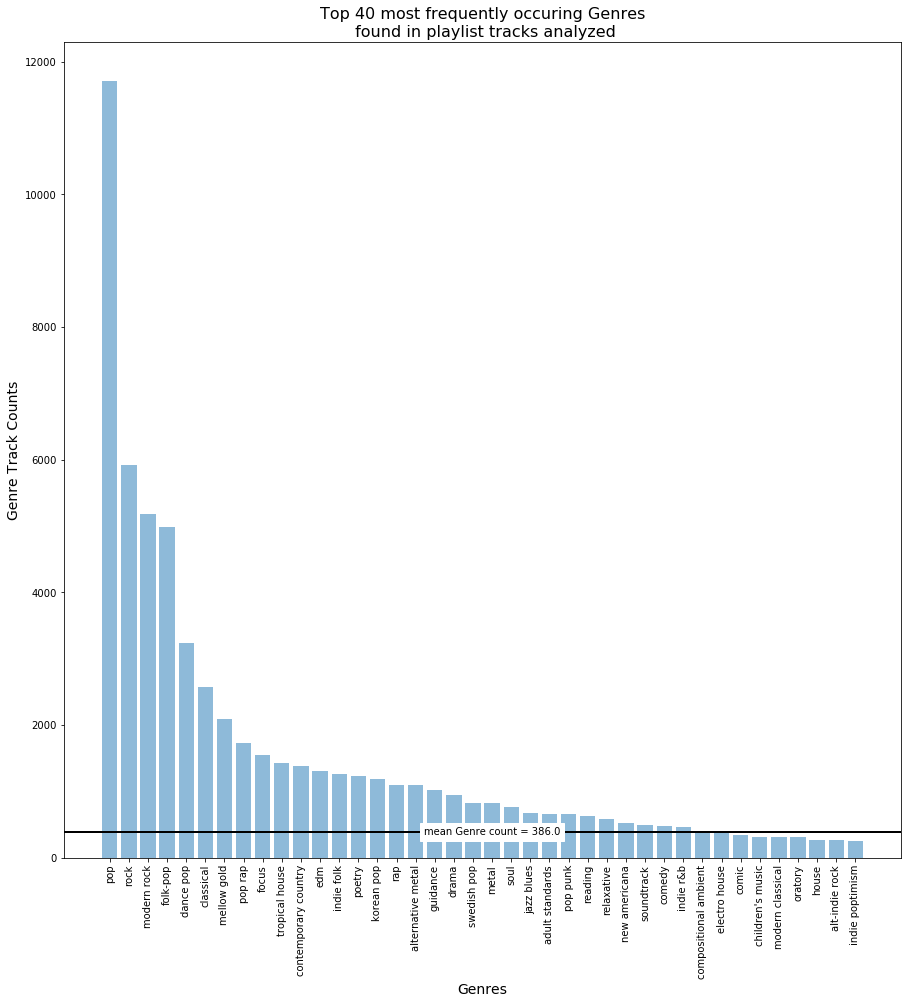

In [62]:
# EDA - Visualize Genres with most the most number of tracks tagged with that Genre
df_genres_sorted = df_genres.sort_values('num_tracks',ascending=False)
asd = df_genres_sorted.head(n=40)
mean_genre = np.round(np.mean(df_genres.num_tracks))
objects  = tuple(list(asd['genre']))
y_pos = np.arange(asd.shape[0])
performance = list(asd['num_tracks'])
plt.figure(figsize=(15,15))
plt.xticks(y_pos, objects, rotation='vertical')
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.axhline(y = np.mean(df_genres.num_tracks), linewidth=2, color = 'k')
plt.text(20, np.mean(df_genres.num_tracks), 'mean Genre count = '+str(mean_genre), fontsize=10, va='center', ha='center', backgroundcolor='w')
plt.title("Top 40 most frequently occuring Genres\n found in playlist tracks analyzed", fontsize = 16)
plt.ylabel("Genre Track Counts", fontsize = 14)
plt.xlabel("Genres", fontsize = 14)
plt.show()

####  Which Genres have more Explicit lyrics on average?  

We plotted the top 40 most Explicit Genres, considering only the Genres having a significant Track count, where significant is defined as a Genre having the mean number of Tracks (371) or more associated with it. =

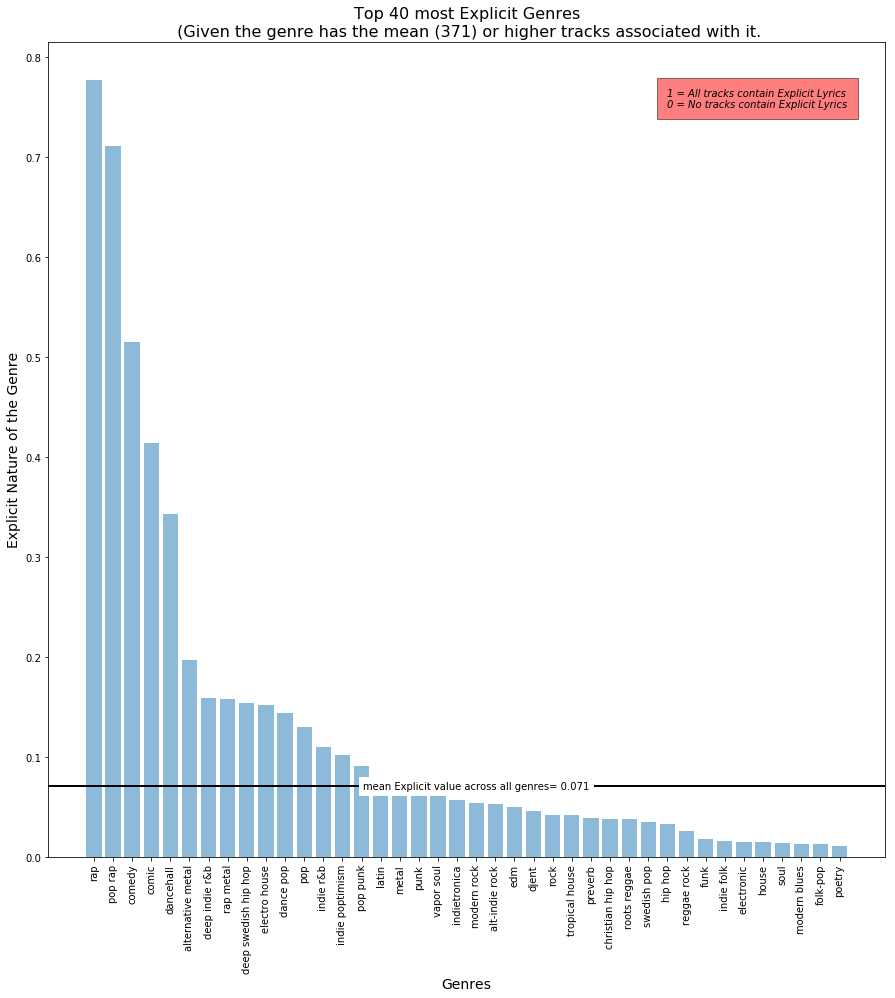

In [64]:
# EDA - Explore which Genres are more likely to have Explicit Lyrics.
# Most genres aren't explicit in nature based on mean value.
asd = df_genres[df_genres['num_tracks'] > 100].sort_values('mean_track_explicit',ascending=False).head(n=40)
mean_explicit = np.around(np.mean(df_genres.mean_track_explicit), decimals = 3)
objects  = tuple(list(asd['genre']))
y_pos = np.arange(asd.shape[0])
performance = list(asd['mean_track_explicit'])
plt.figure(figsize=(15,15))
plt.xticks(y_pos, objects, rotation='vertical')
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.axhline(y = np.mean(df_genres.mean_track_explicit), linewidth=2, color = 'k')
plt.text(20, np.mean(df_genres.mean_track_explicit), 'mean Explicit value across all genres= '+str(mean_explicit), fontsize=10, va='center', ha='center', backgroundcolor='w')
plt.title("Top 40 most Explicit Genres\n (Given the genre has the mean (371) or higher tracks associated with it.",  
          fontsize = 16)
plt.ylabel("Explicit Nature of the Genre", fontsize = 14)
plt.xlabel("Genres", fontsize = 14)
plt.text(30, 0.75, '1 = All tracks contain Explicit Lyrics\n0 = No tracks contain Explicit Lyrics', style='italic',
        bbox={'facecolor':'red', 'alpha':0.5, 'pad':10})
plt.show()

#### Are there any trends where similar genres have more explicit lyrics on average?  

In general, most Genre associated Tracks don't have Explicit lyrics, the average value being 0.059 (closer to 0).  'rap' and 'hip hop' (two closely related Genres) dominate the 20 positions with significantly larger 'Explicit' values than most genres.  Two comedy related genres also appear in the top 20.

#### Which genres have the most followers

In [65]:
df_genres.head()

,genre,num_playlists,num_tracks,mean_num_tracks,mean_track_explicit,mean_track_popularities,mean_track_duration,std_track_popularities,max_track_popularities,mean_artist_popularities,std_artist_popularities,max_artist_popularities,mean_artist_followers,std_artist_followers,max_artist_followers,mean_artist_views,std_artist_views,max_artist_views,followers
0,adult standards,18,662,36.777778,0.003021,188168.638973,30.463746,20.779181,84,54.297844,18.010822,97,263476.621294,6.275888e+05,7430477,1.092735e+06,2.110189e+06,14041072,51738.388889
1,folk-pop,80,4980,62.250000,0.012651,231950.842771,36.934940,20.903896,97,58.062476,15.569894,99,379653.359763,1.155905e+06,14120621,5.046639e+05,1.403732e+06,23129006,200714.587500
2,movie tunes,1,25,25.000000,0.000000,190702.320000,30.280000,19.564294,65,55.812500,18.288380,93,338013.468750,9.851293e+05,5391500,9.017510e+05,2.081898e+06,7986487,2502.000000
3,vocal jazz,3,103,34.333333,0.000000,287243.359223,41.456311,14.232996,71,52.258333,12.377059,86,129371.258333,3.934171e+05,3090044,4.551741e+05,1.003524e+06,6830283,184372.333333
4,indie pop,1,100,100.000000,0.020000,220538.090000,44.010000,16.680824,67,53.287129,10.331473,86,61271.267327,1.327780e+05,672387,1.321441e+05,3.643028e+05,2432600,900951.000000


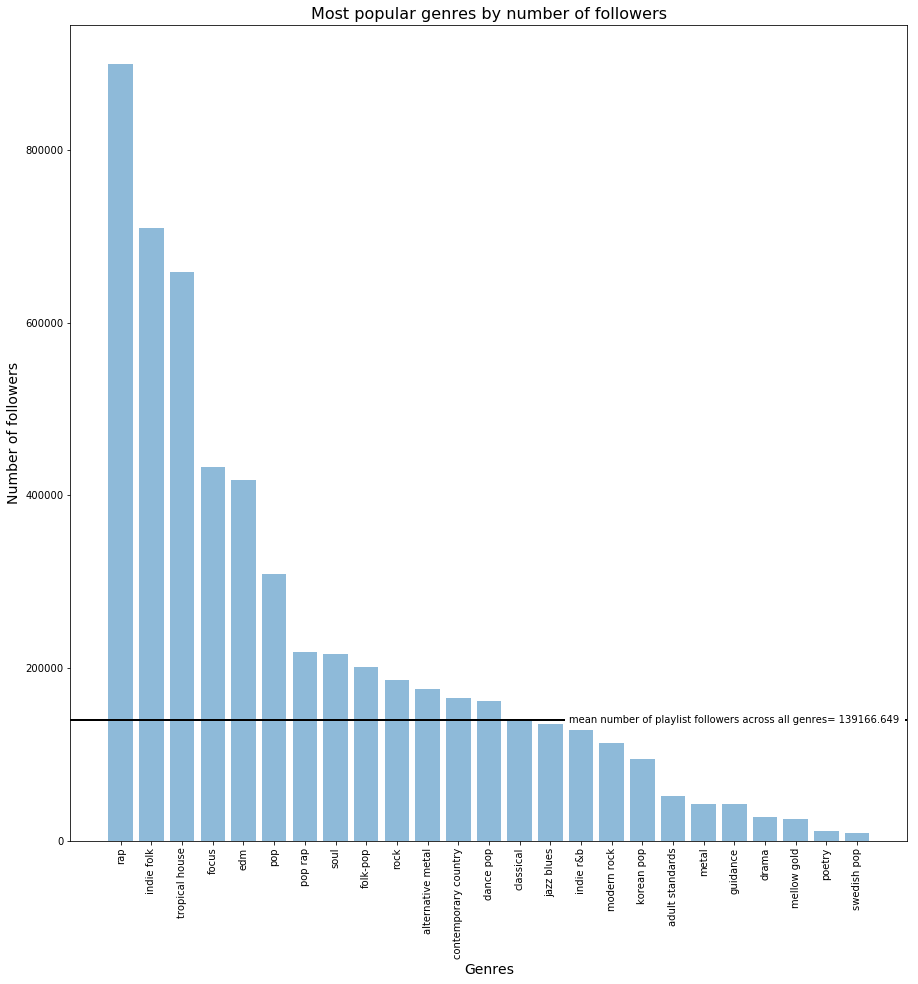

In [69]:
# EDA - Explore which Genres are more likely to have Explicit Lyrics.
# Most genres aren't explicit in nature based on mean value.
asd = df_genres[df_genres['num_playlists'] > 10].sort_values('followers',ascending=False).head(n=40)
mean_followers = np.around(np.mean(df_genres.followers), decimals = 3)
objects  = tuple(list(asd['genre']))
y_pos = np.arange(asd.shape[0])
performance = list(asd['followers'])
plt.figure(figsize=(15,15))
plt.xticks(y_pos, objects, rotation='vertical')
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.axhline(y = np.mean(df_genres.followers), linewidth=2, color = 'k')
plt.text(20, np.mean(df_genres.followers), 'mean number of playlist followers across all genres= '+str(mean_followers), fontsize=10, va='center', ha='center', backgroundcolor='w')
plt.title("Most popular genres by number of followers", fontsize = 16)
plt.ylabel("Number of followers", fontsize = 14)
plt.xlabel("Genres", fontsize = 14)
plt.show()

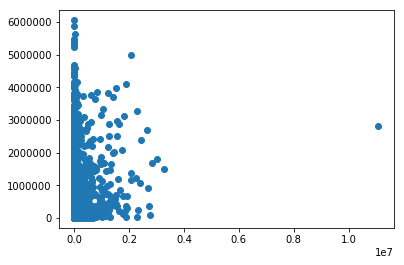

In [13]:
meanArtistFollowers = []
for playlist in playlists:
    artistFollowers = []
    for track in playlist.tracks:
        if track.artist1:
            artistFollowers.append(track.artist1.followers)
        if track.artist2:
            artistFollowers.append(track.artist2.followers)
        if track.artist3:
            artistFollowers.append(track.artist3.followers)
    meanArtistFollowers.append(np.mean(artistFollowers))
plt.scatter([playlist.followers for playlist in playlists], meanArtistFollowers)
plt.show()

In [650]:
genresCount = Counter(getAllGenres())
print(genresCount)

Counter({'pop': 12537, 'dance pop': 10022, 'pop rap': 7850, 'rock': 6704, 'modern rock': 6418, 'rap': 5974, 'pop christmas': 5340, 'folk-pop': 5128, 'tropical house': 4913, 'indie folk': 4873, 'post-teen pop': 4818, 'mellow gold': 4570, 'indie pop': 4555, 'classic rock': 4513, 'pop rock': 4369, 'neo mellow': 4359, 'singer-songwriter': 4239, 'r&b': 4114, 'alternative rock': 4089, 'edm': 3762, 'indie rock': 3716, 'album rock': 3710, 'hip hop': 3677, 'soft rock': 3546, 'stomp and holler': 3472, 'chamber pop': 3346, 'southern hip hop': 3256, 'urban contemporary': 3171, 'indietronica': 3147, 'trap music': 3134, 'indie r&b': 3083, 'classical': 3027, 'folk rock': 2890, 'alternative metal': 2694, 'new americana': 2600, 'hip pop': 2548, 'soul christmas': 2486, 'roots rock': 2472, 'soul': 2393, 'post-grunge': 2375, 'romantic': 2296, 'quiet storm': 2294, 'indie poptimism': 2279, 'electro house': 2256, 'hard rock': 2256, 'classic funk rock': 2185, 'adult standards': 2167, 'motown': 2165, 'blues-ro

# Clustering Genres By Co-Occurrence

In [651]:
genresCount = Counter(getAllGenres())
genres = genresByCount(getAllGenres())
def distance(genre1, genre2):
    if genre1 == genre2:
        return 0
    
    # Take the set of genres that genre1 is in, and the set that genre2 is in
    # Compute the distance as a percentage that they have in common
    opportunities = 0
    missed = 0
    mostPopular = genre2 if genres.index(genre1) > genres.index(genre2) else genre1
    leastPopular = genre1 if genres.index(genre1) > genres.index(genre2) else genre2
    unpopular_missed_penalty = float(genresCount[leastPopular] / genresCount[mostPopular])
    popular_missed_penalty = np.reciprocal(unpopular_missed_penalty)
    
    for playlist in playlists:
        if leastPopular in playlist.genres or mostPopular in playlist.genres:
            if mostPopular not in playlist.genres:
                opportunities += popular_missed_penalty
                missed += popular_missed_penalty
            elif leastPopular not in playlist.genres:
                opportunities += unpopular_missed_penalty
                missed += unpopular_missed_penalty
            else:
                # They're both in it
                opportunities += 1
    retDist = float(missed / opportunities)
    if np.isnan(retDist):
        return 1.0
    return retDist


# 0 = when genre1 shows up, genre2 does also, and vice versa
# 1 = they do not show up in the same playlists

def distance_between_groups(group1, group2):
    if group1 == group2:
        return 0.0
    avgs = []
    for genre1 in group1:
        for genre2 in group2:
            avgs.append(distance(genre1, genre2))
    if len(avgs) == 0:
        print("0 averages")
        print(group1)
        print(group2)
        raise Exception("Shit")
    return np.mean(avgs)

In [652]:
#dbscan = DBSCAN(eps=0.1, min_samples=3, metric='precomputed')
#dbscan.fit(distance_matrix)
#print(dbscan.labels_)
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.cluster import FeatureAgglomeration

from collections import defaultdict

def print_labels_with_vals(labels, groups):
    labels_dict = dict()
    print("LENGTH OF LABELS:")
    print(len(labels))
    unsorted= []
    for i in range(len(labels)):
        if str(labels[i]) not in labels_dict:
            labels_dict[str(labels[i])] = []
        if str(labels[i]) == '-1':
            # These shouldn't be here. I don't know why they're here with min group size = 1
            unsorted.append(groups[i])
        else:
            labels_dict[str(labels[i])].extend(groups[i])
    return_groups = [value for key, value in labels_dict.items() if len(value) != 0]

    return_groups.extend(unsorted)

    return return_groups


# Compute distance matrix for genres
playlistGenres = []
for playlist in playlists:
    playlistGenres.extend(playlist.mainGenre)
playlistGenres = list(set(playlistGenres))


'''distance_matrix = []
for genre1 in playlistGenres:
    row = []
    for genre2 in playlistGenres:
        row.append(distance(genre1, genre2, .1))
    distance_matrix.append(row)

eps_vals = [.001, .001, .005, .0075, .01, .05, .075, .1, .12, .15, .2]
for eps_val in eps_vals:
    dbscan = DBSCAN(eps=eps_val, min_samples=1, metric='precomputed', algorithm='brute')
    dbscan.fit(distance_matrix)
    score = silhouette_score(distance_matrix, dbscan.labels_, metric='precomputed')
    print(str(eps_val)+" : "+str(score))'''
    

'distance_matrix = []\nfor genre1 in playlistGenres:\n    row = []\n    for genre2 in playlistGenres:\n        row.append(distance(genre1, genre2, .1))\n    distance_matrix.append(row)\n\neps_vals = [.001, .001, .005, .0075, .01, .05, .075, .1, .12, .15, .2]\nfor eps_val in eps_vals:\n    dbscan = DBSCAN(eps=eps_val, min_samples=1, metric=\'precomputed\', algorithm=\'brute\')\n    dbscan.fit(distance_matrix)\n    score = silhouette_score(distance_matrix, dbscan.labels_, metric=\'precomputed\')\n    print(str(eps_val)+" : "+str(score))'

In [653]:
from itertools import chain
from itertools import groupby
def match_groups(groups, eps, big_groups_limit=20, directly_compare=False):
    
    big_groups = []
    little_groups = []
    for group in groups:
        if len(group) > big_groups_limit:
            big_groups.append(group)
        else:
            little_groups.append(group)
            

    print("BIG AND LITTLE")
    print(len(little_groups))
    print(len(big_groups))
    distances = []
    for genre_group1 in little_groups:
        row = []
        for genre_group2 in little_groups:
            row.append(distance_between_groups(genre_group1, genre_group2))
        distances.append(row)
        print(row)
        
    if directly_compare:
        pairsToCombine = defaultdict(list)
        for i in range(len(little_groups)):
            row = []
            for j in range(i, len(little_groups)):
                if i != j:
                    if  distance_between_groups(little_groups[i], little_groups[j]) < eps:
                        pairsToCombine[i].append(j)
                        pairsToCombine[j].append(i)

        print("LENGTH OF PAIRS:")
        print(len(pairsToCombine))
        for key, values in pairsToCombine.items():
            combined = little_groups[key]
            for matchingIdx in values:
                combined.extend(little_groups[matchingIdx])
            little_groups[key] = sorted(list(set(combined)))
        print("REDUCING DUPLICATES")
        groups = [k for k,v in groupby(sorted(little_groups))]
        
    else:
        
        dbscan = DBSCAN(eps=eps, min_samples=1, metric='precomputed', algorithm='auto')
        dbscan.fit(distances)
        groups = print_labels_with_vals(dbscan.labels_, little_groups)
    
    groups.extend(big_groups)

    return groups

playlistGenres = list(set([playlist.mainGenre[0] for playlist in playlists]))

distance_matrix = []
for genre1 in playlistGenres:
    row = []
    for genre2 in playlistGenres:
        row.append(distance(genre1, genre2))
    distance_matrix.append(row)

# DB scan mostly does a good job, but splits some groups into too large of a category
# and others cannot be sufficiently grouped
print("PASS 1")
dbscan = DBSCAN(eps=.6, min_samples=1, metric='precomputed', algorithm='brute')
dbscan.fit(distance_matrix)

PASS 1


DBSCAN(algorithm='brute', eps=0.6, leaf_size=30, metric='precomputed',
    metric_params=None, min_samples=1, n_jobs=1, p=None)

In [654]:
print(len(playlistGenres))

190


In [655]:
label_dict = defaultdict(list)
unsorted = []
print(dbscan.labels_)
for i in range(len(dbscan.labels_)):
    label_dict[str(dbscan.labels_[i])].append(playlistGenres[i])
    if dbscan.labels_[i] == -1:
        unsorted.append([playlistGenres[i]])
groups = [value for key, value in label_dict.items()]
groups.extend(unsorted)

print(len(groups))
print(len(groups))
for group in groups:
    print(group)


[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14   4  15  16
  17  18  10  10  10  10  12  10  19  20  19  21  10  22  23  12  24  12
  25  26  27  28  29  30  31  32  17  33  34  28  10  35  36  10  37  38
  18  39  10  40  41  42  43  44  34  45  46  47  48  49  50  51  10  10
  19  52  53  54  19  12  55  10  56  17  10  10  10  10  57  19  12  58
  45  59  60  10  61  10  12  45  62  63  10  12  64  10  10  34  65  41
  66  10  67  68  69  70  10  71  34  12  10  52  72  10  73  74  75  10
  62  76  62  10  10  34  77  78  79  52  80  38  81  82  83  84  85  62
  86  12  87  46   9  45  10  88  12  89  90  10  91  92  93  10  94  95
  10  19  53  96  10  97  98  99 100  15 101 102 103 104  87 105 106 107
 103 108  12 109  10  80 110 111 112  81]
113
113
['pop punk']
['folk rock']
['punk']
['gospel']
['swedish pop', 'swedish indie rock']
['hollywood']
['spanish reggae']
['movie tunes']
['indie poptimism']
['country', 'contemporary country']
['reading', 'rap', 'modern roc

In [656]:
print("PASS 2")
print(len(groups))
groups2 = match_groups(groups, .9, 6, True)
print("LEN GROUPS 2:")
print(len(groups2))
for group in groups2:
    print(group)



PASS 2
113
BIG AND LITTLE
111
2
[0.0, 1.0, 0.80405925292530067, 1.0, 0.99671759562273698, 1.0, 1.0, 1.0, 0.9728145145792183, 0.99173698586237791, 1.0, 0.97202487724136533, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96955823909587857, 1.0, 0.97622473514518704, 1.0, 0.95333829696419958, 1.0, 1.0, 1.0, 0.98465752146545094, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99632012688351868, 1.0, 0.98381502683880273, 0.98373784089823868, 0.99583810636435621, 1.0, 1.0, 1.0, 1.0, 0.98336171289636942, 0.99627223664075448, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99131683976165397, 1.0, 1.0, 0.98830577096760153, 1.0, 0.98028354642100046, 1.0, 1.0, 0.99213232934322437, 0.89603585998715063, 1.0, 0.98571930898171412, 1.0, 1.0, 1.0, 1.0, 0.96703424619147316, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95116438282111282, 1.0, 1.0, 0.99320268037344439, 0.87891095126483276, 0.88097586306715991, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.69245045471924849, 1.0, 1.0, 1.0, 1.0, 0.98758472741063297, 1.0, 0.93086759727711088, 1.0, 1.0, 1.0, 1.0,

[1.0, 0.94625508306545869, 0.97888076990187312, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.83665506186375194, 0.0, 1.0, 1.0, 0.9522726851811274, 1.0, 1.0, 0.97405374005333223, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96324147067166943, 1.0, 1.0, 0.88021762759760647, 1.0, 0.96881453805632201, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99554286751079357, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9138341168086147, 1.0, 1.0, 0.9869716471644262, 1.0, 1.0, 0.86422426801332475, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.94328244764609281, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.97202487724136533, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.95628024696774261, 1.0, 1.0, 1.0, 0.95068756469022642, 0.96441139035164336, 1.0, 1.0, 1.0, 1.0, 0.98779604732569426, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.90987397756173061, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98568703324683282, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.95333829696419958, 1.0, 1.0, 1.0, 0.99321200226932449, 1.0, 0.99773526217360853, 1.0, 0.86216744309358451, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.95429048562066299, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9744866685463982, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9804444854427754, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0

[1.0, 1.0, 1.0, 1.0, 0.99357092116097889, 1.0, 1.0, 1.0, 0.98761540701997963, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96795921198668144, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99108143246717639, 1.0, 1.0, 0.99810012106768742, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99259336351591654, 1.0, 1.0, 1.0, 0.98908289639067848, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99805663664509336, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98868117957685231, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9724851667188541, 1.0, 1.0, 1.0, 1.0, 1.0, 0.97584003578824996, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99707169880719149, 1.0, 0.60409247794883036, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.98381502683880273, 0.92646884650494155, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98570569884104986, 1.0, 1.0, 0.99600713108985017, 0.9581636343272395, 0.97811277071976488, 1.0, 0.99123717109950049, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96497914083656333, 1.0, 1.0, 1.0, 1.0, 0.99986276398661156, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99941260938592702, 0.0, 0.99949125973331598, 1.0, 1.0, 0.95048380949449429, 1.0, 1.0, 1.0, 1.0, 0.98885196684690713, 1.0, 1.0, 0.988701430477675, 1.0, 1.0, 1.0, 1.0, 0.99972676113172398, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 0.85273588013821677, 1.0, 0.96374167719985726, 0.98330762487885348, 0.99011756451522825, 1.0, 1.0, 1.0, 0.97865916888853532, 0.96881453805632201, 1.0, 0.99830492117720548, 0.82374579803279269, 0.98437664562439564, 0.98983165301050047, 1.0, 0.99786981649480833, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75287326596433513, 1.0, 

[0.98830577096760153, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99772536802870326, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99286058269532074, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.83241570971632317, 1.0, 0.99152370588200633, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99138122897128966, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.988701430477675, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.97585909936939186, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99333691083087383, 1.0, 0.99056412222350387, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9774043498894307, 1.0, 1.0, 0.82955898005723017, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96987657046608999, 1.0, 1.0, 0.0, 1.0, 1.0, 0.9455133032114218, 1.0, 1.0, 1.0, 1.0, 1.0, 0.84772142871163403, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.91409793465007172, 1.0, 1.0, 0.96638657139834017, 1.0, 1.0, 1.0, 0.91721746322614672, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.97766073589565194, 1.0, 1.0, 1.0, 0.99203268838766268, 0.89658335438966019, 1.0, 0.97055676502665345, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.70483233439798887, 1.0, 1.0, 0.81749654952755002,

[1.0, 1.0, 1.0, 1.0, 0.73776127045337847, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95880601552457401, 1.0, 1.0, 1.0, 0.9897554270719594, 1.0, 1.0, 1.0, 0.95769424008612958, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.83338831381565648, 1.0, 1.0, 0.94269252743502052, 1.0, 0.99682787331156708, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.995680423093949, 0.88298670248253541, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.93637069903147274, 1.0, 0.99192442148548066, 1.0, 1.0, 1.0, 0.93205398112809568, 1.0, 1.0, 1.0, 1.0, 0.95391738191405806, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 0.96940285021263539, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98640420880507618, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99535925361483846, 1.0, 0.9844040228901203, 

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.91321717900344024, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.92053727333781077, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.83241570971632317, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.93637069903147274, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.88528891983077174, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.963467361665587, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.66713290076111698, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.82238877291818635, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.89584828472041667, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95648660144619335, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.94309516382051228, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.97740722909202349, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.92484296367042573, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.85301801571762204, 0.94328244764609281, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96781732675243681, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

In [657]:
print(len(groups2))

74


In [658]:
groups3 = match_groups(groups2, .975, 15)
print("LEN GROUPS 3:")
print(len(groups3))
for group in groups3:
    print(group)


BIG AND LITTLE
60
14
[0.0, 0.99721003615597692, 0.9969564030792476, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99825657818938496, 0.99569742820956197, 0.9979660078876158, 1.0, 1.0, 1.0, 1.0, 0.96721018522580693, 1.0, 0.94655960371978265, 0.95660858950172012, 1.0, 0.99230769230769234, 0.9979660078876158, 0.99755920946513899, 0.99313433592076239, 1.0, 1.0, 0.95904172408743615, 0.98634724136247875, 0.97269448272495751, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95068756469022642, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.99721003615597692, 0.0, 0.81114124029568369, 1.0, 0.99990652539142055, 1.0, 0.99113669867091803, 0.98601314384912964, 0.99793732077567565, 0.99830584510786513, 0.99811760567540564, 0.99802261158728056, 0.99518053935661299, 0.98649473792071496, 0.98876815076190638, 0.98716446017814663, 0.99526886051388219, 0.99922129188826991, 0.99967464767308101, 0.98231516678087227, 0.99837015090556047, 0.9974247210237942, 0.998790336

[0.99825657818938496, 0.98649473792071496, 0.98526698682259839, 0.99725738527536811, 1.0, 1.0, 0.993336353802454, 0.99559263698530887, 0.99954772300127248, 1.0, 1.0, 1.0, 1.0, 0.0, 0.79152354122105317, 0.76357680380639825, 0.9988449149729054, 0.99765029710576181, 1.0, 0.99909994100621669, 0.99963738337842456, 0.99750145063394002, 0.99968077663528854, 1.0, 0.99612937468753826, 0.9871967693332232, 0.76486122475353435, 0.75301373841349761, 0.99771239619338081, 1.0, 1.0, 0.98933730248978979, 0.9919576342889187, 0.99046172448816128, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9980826624024759, 1.0, 0.99965445061848845, 1.0, 1.0, 0.99763953235303637, 0.99460802392115621, 1.0, 0.9947808316782758, 1.0, 1.0, 0.99511430812511659, 0.99771716040802083, 1.0, 0.99872459614349751, 1.0, 0.99841036534826877, 1.0, 0.99974046361915303, 0.99693914680631457]
[0.99569742820956197, 0.98876815076190661, 0.98774707355844338, 0.99725738527536811, 1.0, 1.0, 0.99367849665808738, 0.99574470047670149, 0.99954772300127248, 1.0,

[0.9979660078876158, 0.98424386090750082, 0.98281148462636458, 0.99680028282126276, 1.0, 1.0, 0.99222574610286285, 0.99541591777052552, 0.99947234350148451, 1.0, 1.0, 1.0, 1.0, 0.76486122475353435, 0.79100445656484908, 0.75987446790201163, 0.99865240080172291, 0.99725867995672213, 1.0, 0.9989499311739195, 0.9995769472748286, 0.99708502573959679, 0.99962757274116987, 1.0, 0.99935178696492255, 0.98506289755542709, 0.0, 0.7213578643025369, 0.99733112889227771, 1.0, 1.0, 0.99210074430380291, 0.99545063419096513, 0.99376646331342378, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99776310613622188, 1.0, 0.99959685905490325, 1.0, 1.0, 0.99891964494153762, 0.9937093612413489, 1.0, 0.99391097029132192, 1.0, 1.0, 0.99616743884606151, 0.99733668714269097, 1.0, 0.99962254369560144, 1.0, 0.99814542623964686, 1.0, 0.99969720755567859, 0.99698638193411804]
[0.99755920946513899, 0.98459735221377565, 0.98319711150593714, 0.99616033938551529, 1.0, 1.0, 0.99114989532132236, 0.99471199021258028, 0.99936681220178136, 1.

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99170730921455197, 0.99462104739425072, 0.9956729794423147, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.988701430477675, 1.0, 1.0, 0.98792954968469593, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99138122897128966, 1.0]
[1.0, 0.99569750312004623, 0.9953063670400506, 1.0, 1.0, 1.0, 1.0, 0.99964373227915093, 1.0, 0.99258337157924192, 0.99175930175471327, 0.98763895263206991, 0.97874739125523258, 0.99965445061848845, 0.99965445061848845, 0.99959685905490325, 1.0, 1.0, 0.98567846328965714, 0.9987150833973637, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99869768085588762, 0.99959685905490325, 0.99951623086588381, 1.0, 1.0, 0.98950807848111511, 0.9617632140775485, 0.98016517445184492, 0.96621201365840192, 1.0, 1.0, 1.0, 0.98591803421952562, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.97794382278732994, 1.0, 0.99849698621797733, 1.0, 1.0, 0

[1.0, 0.99874094592365481, 0.99862648646216889, 1.0, 1.0, 1.0, 1.0, 0.99955634789887227, 0.93666216387205148, 0.99071494868475019, 0.98968327631638908, 0.99732359676677185, 1.0, 0.99974046361915303, 0.99974046361915303, 0.99969720755567859, 0.97849884563862788, 1.0, 1.0, 1.0, 0.98291954426417105, 1.0, 1.0, 1.0, 1.0, 0.99086684041639672, 0.99969720755567859, 0.99963664906681426, 0.99543796880318214, 1.0, 1.0, 0.99629650140525272, 0.99593006037800469, 0.99186012075600927, 0.96497914083656333, 1.0, 1.0, 0.99061579860772575, 1.0, 1.0, 1.0, 0.99138122897128966, 0.97963084829682556, 0.93108378817791193, 1.0, 1.0, 1.0, 0.93959374232123838, 0.99793207971568454, 0.96004598216789094, 1.0, 0.99432911981917416, 0.99376592420267862, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.99891423412675273]
[1.0, 0.99320394168208226, 0.99258611819863518, 0.99840913226467032, 0.97554137539343067, 0.99706489951793476, 0.99311309399352565, 0.98757347619213121, 0.99506373745193777, 0.99106513718818079, 0.99101762607419985, 0.9

In [659]:
groups4 = match_groups(groups3, .98, 20)
print("LEN GROUPS 4:")
print(len(groups4))
for group in groups4:
    print(group)

BIG AND LITTLE
9
19
[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]
LENGTH OF LABELS:
9
LEN GROUPS 4:
28
['ambient idm', 'spanish reggae']
['deep swedish hip hop', 'deep swedish indie pop', 'europop', 'swedish indie rock', 'swedish pop', 'swedish punk']
['finnish dance pop']
['footwork']
['guidance']
['korean pop']
['psychedelic rock']
['psychobilly']
['theme']
['afrobeats', 'bluegrass', 'new americana', 'progressive bluegrass', 'stomp and holler', 'blues-rock', 'deep funk', 'funk', 'jazz fusion', 'modern blues', 'new americana', 'new orleans blues', 'smooth jazz', 'stomp and holler', 'christian alternative rock', 'christian m

In [660]:
groups5 = match_groups(groups4, .99, 10, True)
print("LEN GROUPS 5:")
print(len(groups5))
for group in groups5:
    print(group)

BIG AND LITTLE
9
19
[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]
LENGTH OF PAIRS:
0
REDUCING DUPLICATES
LEN GROUPS 5:
28
['ambient idm', 'spanish reggae']
['deep swedish hip hop', 'deep swedish indie pop', 'europop', 'swedish indie rock', 'swedish pop', 'swedish punk']
['finnish dance pop']
['footwork']
['guidance']
['korean pop']
['psychedelic rock']
['psychobilly']
['theme']
['afrobeats', 'bluegrass', 'new americana', 'progressive bluegrass', 'stomp and holler', 'blues-rock', 'deep funk', 'funk', 'jazz fusion', 'modern blues', 'new americana', 'new orleans blues', 'smooth jazz', 'stomp and holler', 'christian alternative 

In [661]:
count = 0
fixed = []
print(len(groups4))
for group in groups4:
    fixed.append(sorted(list(set(group))))
groups = [k for k,v in groupby(sorted(fixed))]
print(len(groups))
for group in groups:
    print(group)

28
28
['adult standards', 'afrobeats', 'bluegrass', 'blues-rock', 'brass ensemble', 'choral', 'christian alternative rock', 'christian hip hop', 'christian music', 'christian relaxative', 'classical', 'classical guitar', 'classify', 'compositional ambient', 'contemporary country', 'contemporary jazz', 'cool jazz', 'country', 'country christmas', 'dancehall', 'deep dutch hip hop', 'deep funk', 'deep german hip hop', 'deep house', 'deep melodic euro house', 'drone folk', 'drum and bass', 'early music', 'electronic', 'filter house', 'fingerstyle', 'focus', 'fourth world', 'free jazz', 'funk', 'gospel', 'grime', 'hardcore techno', 'hawaiian', 'house', 'indian pop', 'j-pop', 'j-rock', 'jazz blues', 'jazz fusion', 'minimal', 'modern blues', 'modern classical', 'neo mellow', 'new americana', 'new orleans blues', 'nu jazz', 'oratory', 'outlaw country', 'post rock', 'progressive bluegrass', 'progressive house', 'redneck', 'reggae', 'reggae rock', 'relaxative', 'roots reggae', 'scorecore', 'smoo

# Regression

In [663]:
# Genre groups to try: 
#     groups contains 46 genre groups
#     groups2 contains 101 genre groups
groups  = [['environmental', 'healing', 'native american', 'sleep', 'environmental', 'healing', 'sleep', 'healing', 'native american'], ['stoner rock'], ['guidance'], ['beats', 'electronic trap'], ['new wave pop'], ['classical guitar', 'classify', 'fingerstyle', 'drum and bass', 'focus', 'compositional ambient', 'modern classical', 'christian relaxative', 'relaxative', 'minimal', 'post rock'], ['country christmas', 'outlaw country', 'dancehall', 'reggae', 'reggae rock', 'roots reggae', 'singer-songwriter'], ['swedish punk'], ['moombahton', 'tropical', 'latin', 'reggaeton'], ['progressive deathcore', 'metalcore', 'rap metal', 'post-screamo'], ['irish folk', 'celtic'], ['theme'], ['trance', 'progressive house'], ['free jazz', 'hollywood', 'movie tunes', 'nursery', "children's christmas", "children's music", 'oratory', 'scorecore', 'soundtrack', 'video game music', 'comic', 'drama', 'comedy', 'reading', 'antiviral pop', 'judaica', 'poetry'], ['hawaiian'], ['r&b', 'urban contemporary'], ['drone folk'], ['ambient idm', 'fluxwork', 'float house'], ['motown', 'swing', 'brill building pop', 'folk rock', 'vocal jazz', 'rock-and-roll', 'adult standards', 'jazz blues', 'cool jazz'], ['bossa nova', 'world'], ['smooth jazz'], ['psychobilly'], ['tech house', 'house', 'grime', 'deep melodic euro house', 'deep house'], ['afrobeats', 'deep dutch hip hop', 'trap francais'], ['indian pop'], ['christian hip hop'], ['christian alternative rock', 'christian music', 'contemporary country', 'country', 'pop christmas', 'neo mellow', 'redneck'], ['bluegrass', 'progressive bluegrass'], ['j-pop', 'j-rock'], ['contemporary jazz', 'fourth world', 'swedish jazz', 'electronic', 'indie jazz', 'nu jazz', 'trip hop'], ['barnmusik', 'vintage swedish pop'], ['neo-singer-songwriter'], ['hardcore techno'], ['early music', 'classical', 'choral', 'wind ensemble', 'brass ensemble'], ['underground hip hop'], ['rock en espanol'], ['djent', 'gothic metal', 'progressive metal', 'speed metal'], ['disco', 'blues-rock', 'soul', 'funk', 'classic funk rock', 'soul christmas', 'deep funk', 'modern blues', 'new orleans blues'], ['chanson'], ['psychedelic rock'], ['alt-indie rock', 'alternative emo', 'filter house', 'deep danish pop', 'danish pop', 'indie psych-rock', 'preverb', 'indie rock'], ['chillhop', 'deep indie r&b', 'footwork', 'indie r&b', 'indie poptimism', 'vapor soul'], ['gypsy jazz', 'jazz fusion'], ['deep swedish indie pop', 'swedish idol pop', 'swedish pop', 'swedish indie rock', 'deep swedish hip hop', 'swedish indie pop', 'europop'], ['alternative metal', 'black metal', 'punk', 'rock', 'viking metal', 'pagan black metal', 'death metal', 'modern rock', 'classic rock', 'folk-pop', 'pop punk', 'mellow gold', 'indie folk', 'new americana', 'norwegian indie', 'technical death metal', 'metal', 'alternative rock', 'indie pop', 'stomp and holler'], ['tropical house', 'hip hop', 'strut', 'pop', 'italian arena pop', 'destroy techno', 'deep german hip hop', 'indietronica', 'finnish dance pop', 'electro house', 'kompa', 'gospel', 'korean pop', 'deep hardstyle', 'edm', 'nerdcore', 'rap', 'dance pop', 'pop rap']]
groups2 = [['afrobeats', 'azonto', 'azontobeats'], ['world', 'afrobeat', 'mande pop'], ['irish country', 'irish folk', 'celtic', 'jig and reel'], ['screamo', 'post-screamo'], ['horror punk', 'psychobilly', 'rockabilly'], ['melodic death metal', 'viking metal', 'folk metal'], ['symphonic metal', 'power metal', 'gothic metal'], ['urban contemporary', 'r&b'], ['jazz blues', 'soul blues', 'memphis blues'], ['christian hip hop', 'christian uplift', 'gothic rock'], ['christian music', 'ccm', 'christian alternative rock'], ['new orleans blues', 'funk', 'deep funk'], ['indian pop', 'filmi', 'desi'], ['french indie pop', 'french pop', 'ye ye', 'cabaret', 'chanson'], ['underground pop rap', 'indie rockism', 'indie poptimism'], ['orchestral'], ['soul', 'disco', 'classic funk rock'], ['show tunes', 'post-teen pop', 'broadway', 'hollywood', 'new age'], ['britpop'], ['jazz', 'cool jazz', 'avant-garde jazz'], ['contemporary jazz', 'fourth world', 'dark jazz'], ['poetry', 'musique pour enfants', 'british folk', 'experimental'], ['progressive metal', 'neo classical metal', 'djent', 'jazz metal'], ['dance rock', 'new wave pop'], ['viral pop'], ['psychedelic rock'], ['pop christmas'], ['outlaw country', 'country christmas'], ['motivation', 'guidance'], ['nursery', "children's music", "children's christmas"], ['latin pop', 'trap latino', 'reggaeton', 'tropical', 'latin jazz', 'latin'], ['future funk', 'vaporwave', 'spanish reggae'], ['shimmer pop', 'alternative hip hop'], ['ukulele', 'hawaiian', 'world christmas'], ['trap francais', 'francoton'], ['pagan black metal', 'black metal', 'voidgaze'], ['rock en espanol', 'latin alternative'], ['contemporary country', 'lift kit', 'redneck', 'country', 'country road'], ['sleep', 'environmental'], ['art rock'], ['progressive house', 'progressive uplifting trance', 'trance'], ['indie pop'], ['j-pop', 'japanese r&b', 'j-dance', 'j-rock'], ['bass music'], ['vintage swedish pop', 'barnmusik'], ['pop punk', 'punk', 'anthem emo', 'emo', 'ska'], ['deep euro house', 'deep melodic euro house', 'groove room'], ['swedish alternative rock', 'danspunk', 'swedish punk'], ['vocal house', 'disco house', 'outsider house', 'deep house', 'float house'], ['danish pop', 'deep danish pop', 'garage rock'], ['indie anthem-folk'], ['swing', 'traditional swing', 'vintage jazz', 'christmas', 'jump blues'], ['hardcore techno'], ['meditation', 'healing'], ['modern blues', 'country blues', 'blues-rock'], ['technical death metal', 'death metal', 'brutal death metal'], ['doo-wop', 'brill building pop', 'rock-and-roll'], ['alternative emo'], ['gypsy jazz', 'jazz fusion', 'jazz funk', 'jazz bass'], ['swedish pop', 'europop', 'classic swedish pop', 'eurovision', 'swedish eurodance', 'swedish folk pop'], ['swedish indie pop', 'swedish indie rock', 'folkmusik', 'deep swedish indie pop'], ['movie tunes'], ['free jazz'], ['indie jazz', 'contemporary post-bop'], ['praise', 'christian christmas', 'gospel'], ['alternative rock'], ['chillhop'], ['mellow gold', 'soft rock'], ['roots rock'], ['pop rock'], ['irish rock'], ['uk garage'], ['hard rock'], ['native american'], ['neo mellow'], ['deep latin alternative'], ['traditional folk'], ['moombahton'], ['theme'], ['underground hip hop'], ['vapor soul'], ['oratory'], ['folk rock'], ['motown'], ['soul christmas'], ['album rock'], ['classic rock'], ['swedish jazz', 'adult standards', 'samba', 'deep swedish hip hop', 'swedish hip hop', 'swedish idol pop', 'bossa nova', 'vocal jazz'], ['reading', 'polish indie', 'antiviral pop', 'drama', 'skate punk', 'comic', 'comedy rock', 'deep comedy', 'hoerspiel', 'comedy', 'otacore', 'judaica', 'deep italo disco'], ['compositional ambient', 'video game music', 'soundtrack', 'deep chiptune', 'focus', 'bow pop', 'retro electro', 'drift', 'scorecore', 'relaxative', 'christian relaxative', 'psychill'], ['modern rock', 'k-indie', 'hip house', 'british alternative rock', 'norwegian indie', 'deep australian indie', 'indie folk', 'folk-pop', 'indie rock', 'finnish pop', 'deep dutch hip hop', 'strut', 'bluegrass', 'k-pop', 'mandopop', 'dance pop', 'classic icelandic pop', 'korean pop', 'folk', 'italian arena pop', 'rock', 'italian pop', 'alt-indie rock', 'finnish dance pop', 'pop', 'german hip hop', 'progressive bluegrass', 'french indietronica', 'singer-songwriter', 'neo-psychedelic', 'chamber pop', 'jam band', 'deep german hip hop', 'turkish pop'], ['nerdcore', 'rap', 'west coast trap', 'hip hop', 'pop rap', 'southern hip hop', 'detroit hip hop'], ['classify', 'deep big room', 'complextro', 'beats', 'hardstyle', 'liquid funk', 'jazz christmas', 'edm', 'tracestep', 'trap music', 'fingerstyle', 'indietronica', 'bass trap', 'chillstep', 'smooth jazz', 'deep hardstyle', 'destroy techno', 'brostep', 'electro house', 'deep tropical house', 'deep smooth jazz', 'kompa', 'electronic trap', 'tropical house', 'vapor twitch', 'drum and bass'], ['grime', 'deep groove house', 'microhouse', 'house', 'tech house', 'minimal techno', 'funky tech house'], ['post-grunge', 'metalcore', 'alternative metal', 'progressive deathcore', 'nu metal', 'speed metal', 'death core', 'rap metal', 'metal', 'groove metal', 'metropopolis', 'hardcore'], ['filter house', 'abstract hip hop', 'electro swing', 'chillwave', 'acid jazz', 'electronic', 'alternative dance', 'nu jazz', 'trip hop'], ['stomp and holler', 'neo-singer-songwriter', 'new americana', 'garage psych', 'indie punk', 'deep new americana', 'freak folk', 'drone folk', 'indie psych-rock', 'preverb', 'new weird america'], ['minimal', 'baroque', 'avant-garde', 'modern performance', 'serialism', 'composition d', 'wind ensemble', 'modern classical', 'opera', 'classical piano', 'brazilian composition', 'violin', 'romantic', 'classical', 'brass ensemble', 'choral', 'acousmatic', 'classical performance', 'early music', 'classical christmas', 'brass band', 'harpsichord', 'classical guitar', 'early music ensemble', 'canzone napoletana'], ['reggae fusion', 'rock steady', 'dub', 'riddim', 'dancehall', 'reggae rock', 'roots reggae', 'reggae'], ['avantgarde metal', 'psychedelic doom', 'nu gaze', 'stoner rock', 'post rock', 'post-metal', 'dream pop'], ['escape room', 'fluxwork', 'footwork', 'deep indie r&b', 'indie r&b', 'canadian pop', 'ambient idm']]

def playlistToGenreGroup(playlist):
    for i in range(len(groups)):
        if playlist.genres[0] in groups[i]:
            # Return groups index
            return i

def getTrackSimilarityScore(playlist):
    # Compute track similiarity score for a playlist defined as:
    #  (number of tracks in most popular genre group) / (all tracks)
    numGenreTracks = 0
    allTracks = 0
    # collect all genres associated with a playlist's tracks
    for track in playlist.tracks:
        genres = []
        if track.artist1 and track.artist1.genres:
            genres.extend(track.artist1.genres)
        if track.artist2 and track.artist2.genres:
            genres.extend(track.artist2.genres)
        if track.artist3 and track.artist3.genres:
            genres.extend(track.artist3.genres)
        # find the most occuring genre --> gCount[0]
        gCount = genresByCount(genres)
        # Is the track in most popular genre group?
        if gCount and playlist.genreGroup:
            if gCount[0] in groups[playlist.genreGroup]:
                numGenreTracks += 1
        allTracks += 1
    return numGenreTracks/allTracks

In [664]:
for playlist in playlists:
    playlist.genreGroup = playlistToGenreGroup(playlist)
    playlist.similarity = getTrackSimilarityScore(playlist)

In [665]:
# Create features
artistFollowersList = []
artistPopularityList = []
artistViewsList = []
playlistFollowersList = []
playlistNameList = []
tracksPopularityList = []
trackCountsList = []
trackExplicitList = []
trackDurationList = []
for playlist in playlists:
    artistFollowers = []
    artistPopularity = []
    artistViews = []
    trackPopularity = []
    trackCounts = 0
    trackDuration = []
    trackExplicit = []
    for track in playlist.tracks:
        trackCounts += 1
        trackPopularity.append(track.popularity)
        trackDuration.append(track.duration)
        trackExplicit.append(track.explicit)
        if track.artist1:
            artistFollowers.append(track.artist1.followers)
            artistPopularity.append(track.artist1.popularity)
            artistViews.append(track.artist1.views)
        if track.artist2:
            artistFollowers.append(track.artist2.followers)
            artistViews.append(track.artist2.views)
            artistPopularity.append(track.artist2.popularity)
        if track.artist3:
            artistFollowers.append(track.artist3.followers)
            artistPopularity.append(track.artist3.popularity)
            artistViews.append(track.artist3.views)
    trackCountsList.append(trackCounts)
    trackDurationList.append(np.mean(trackDuration))
    trackExplicitList.append(np.mean(trackExplicit))
    tracksPopularityList.append(np.mean(track.popularity))
    artistFollowersList.append(np.mean(artistFollowers))
    artistViewsList.append(np.mean(artistViews))
    artistPopularityList.append(np.mean(artistPopularity))
    playlistFollowersList.append(playlist.followers)
    playlistNameList.append(playlist.name)
    
playlistGenreGroupList = []
playlistSimilarityGroupList = []
for playlist in playlists:
    playlistGenreGroupList.append(playlist.genreGroup)
    playlistSimilarityGroupList.append(playlist.similarity)

In [666]:
# Create data frame for regression modeling
df_spotify = pd.DataFrame(list(zip(playlistNameList, trackCountsList, trackDurationList, 
                                   artistViewsList, artistPopularityList, tracksPopularityList,
                                   trackExplicitList, artistFollowersList, playlistGenreGroupList, 
                                   playlistSimilarityGroupList, playlistFollowersList)),
                                   columns=['Playlist_Name', 'Track_Counts', 'Ave_Track_Duration', 
                                            'Ave_Artist_Views', 'Ave_Artist_Popularity',
                                            'Ave_Track_Popularity', 'Ave_Explicit', 'Ave_Followers', 
                                            'Playlist_Genre_Group', 'Playlist_Similarity', 'Playlist_Followers'])

In [667]:
#  Q: How many NaNs are there in each column with missing data?
#  A:  Very few, so we won't impute
missing_columns = df_spotify.columns[df_spotify.isnull().any()]
df_spotify[missing_columns].isnull().sum()

Playlist_Genre_Group    6
dtype: int64

In [668]:
#  Drop rows with missing datapoints
df_spotify.dropna(axis=0, how='any', inplace=True) 

In [669]:
#  Create dummy variables for "Playlist_Genre_Group"
df_spotify = pd.get_dummies(df_spotify, columns = ['Playlist_Genre_Group'])

#  Remove the last dummy variable, 'Playlist_Genre_Group_45.0', since it's redundant 
remove_cols = ['Playlist_Genre_Group_45.0']
df_spotify = df_spotify[df_spotify.columns.difference(remove_cols)]

# Put 'Playlist_Followers' column back to the end of the dataframe and
# 'Playlist_Name' column at the beginning of the dataframe
cols = list(df_spotify)
cols.insert(len(df_spotify) - 1, cols.pop(cols.index('Playlist_Followers')))
cols.insert(0, cols.pop(cols.index('Playlist_Name')))
df_spotify = df_spotify.reindex(columns= cols)

In [670]:
df_spotify.head()

,Playlist_Name,Ave_Artist_Popularity,Ave_Artist_Views,Ave_Explicit,Ave_Followers,Ave_Track_Duration,Ave_Track_Popularity,Playlist_Genre_Group_0.0,Playlist_Genre_Group_1.0,Playlist_Genre_Group_10.0,...,Playlist_Genre_Group_43.0,Playlist_Genre_Group_44.0,Playlist_Genre_Group_5.0,Playlist_Genre_Group_6.0,Playlist_Genre_Group_7.0,Playlist_Genre_Group_8.0,Playlist_Genre_Group_9.0,Playlist_Similarity,Track_Counts,Playlist_Followers
0,b'The Refugee Playlist',61.848485,6.641898e+05,0.090909,5.641147e+05,227756.227273,62.0,0,0,0,...,0,0,0,0,0,0,0,0.545455,22,16084
1,b'Best of John Peel Sessions',50.064516,8.149162e+05,0.000000,2.297654e+05,276171.466667,8.0,0,0,0,...,0,1,0,0,0,0,0,0.466667,60,17864
2,b'New Noise',53.240385,1.175892e+05,0.070000,9.389038e+04,210771.360000,40.0,0,0,0,...,0,1,0,0,0,0,0,0.220000,100,256892
3,b'Digging Now',64.408602,3.340995e+05,0.090909,3.087468e+05,217517.454545,57.0,0,0,0,...,0,1,0,0,0,0,0,0.477273,88,668423
4,b'Rock Solid',77.320000,1.716571e+06,0.180000,1.728723e+06,247698.080000,67.0,0,0,0,...,0,1,0,0,0,0,0,0.960000,50,944837


In [671]:
def split_data(df):
    # Split data into 25-75 train and test data
    np.random.seed(9001)
    msk = np.random.rand(len(df)) < 0.75
    data_train = df[msk]
    data_test = df[~msk]
    
    # set y data to just the last column, remove last column from the predictor sets
    ytrain = data_train.iloc[:,-1]
    Xtrain = data_train.drop(data_test.columns[len(data_test.columns)-1], axis=1)

    ytest = data_test.iloc[:,-1]
    Xtest = data_test.drop(data_test.columns[len(data_test.columns)-1], axis=1)
    return (ytrain, Xtrain, ytest, Xtest)

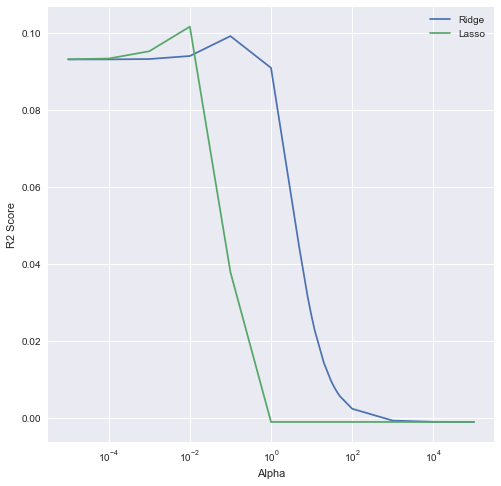

Best Lasso: 0.01
Best Ridge: 0.1


Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [672]:
#
#  Fit a regression model using using Lasso and RidgeCV 
#  and plot R^2 over alpha hyper parameters
#


# 'Playlist_Name'
remove_cols = ['Playlist_Name']
df_spotify = df_spotify[df_spotify.columns.difference(remove_cols)]

# Get all four sets from split data function
ytrain, Xtrain, ytest, Xtest = split_data(df_spotify)

# Perform Lasso and Ridgeregression, then fit and score

# Added additional alpha values around 10 in order to get more precise data around this location
alphas = [.00001, .0001, .001, .01, .1, 1, 5, 8, 10, 12, 20, 30, 35, 40, 45, 50, 100, 1000, 10000, 100000]
r2s = {'ridge':[], 'lasso':[]}

for alpha in alphas:
    # Fit Lasso regression and add r2 results to r2 object
    # Note:  normalize=True yielded lower R^2
    lasso = Lasso(alpha=alpha, normalize=True, fit_intercept=True)
    lasso.fit(Xtrain, ytrain)
    lasso_preds = lasso.predict(Xtest)
    r2s['lasso'].append(r2_score(ytest, lasso_preds))
    
    # Fit Ridge regression add r2 results to r2 object
    ridge = Ridge(alpha=alpha, normalize=True, fit_intercept=True)
    ridge.fit(Xtrain, ytrain)
    ridge_preds = ridge.predict(Xtest)
    r2s['ridge'].append(r2_score(ytest, ridge_preds))
    
# Use a semilogx plot to display alpha values on a normalized scale
plt.figure(figsize=(8,8))
plt.semilogx(alphas, r2s['ridge'], label='Ridge')
plt.semilogx(alphas, r2s['lasso'], label='Lasso')
plt.ylabel("R2 Score")
plt.xlabel("Alpha")
plt.legend()
plt.show()

# Get the best r2 score found for both ridge and lasso
winningRidge = np.argmax(r2s['ridge'])
winningLasso = np.argmax(r2s['lasso'])
print("Best Lasso: "+str(alphas[winningLasso]))
print("Best Ridge: "+str(alphas[winningRidge]))

# Plot all r2 scores by their alpha value
lasso = Lasso(alpha=alphas[winningLasso], fit_intercept=True)
lasso.fit(Xtrain, ytrain)

ridge = Ridge(alpha=alphas[winningRidge], fit_intercept=True)
ridge.fit(Xtrain, ytrain)

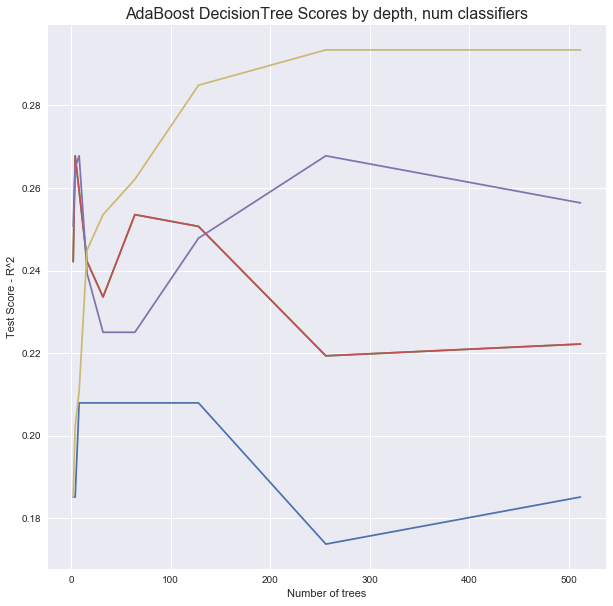

In [674]:
#
#  Fit a AdaBoost regression model using decision tree
#
depths = [1, 2, 4, 10, None]
tree_nums = [2, 4, 8, 16, 32, 64, 128, 256, 512]

scores = []
for depth in depths:
    depth_scores = []
    for tree_num in tree_nums:
        dtc = DecisionTreeClassifier(max_depth=depth)
        ada = AdaBoostClassifier(dtc, learning_rate=0.05, n_estimators=tree_num)
        ada.fit(Xtrain, ytrain)
        depth_scores.append(ada.score(Xtest, ytest))
    scores.append(depth_scores)

plt.figure(figsize = (10, 10))
plt.title('AdaBoost DecisionTree Scores by depth, num classifiers', fontsize = 16)
plt.xlabel('Number of trees')
plt.ylabel('Test Score - R^2')
plt.plot(tree_nums, scores[0], label='depth 1')
plt.plot(tree_nums, scores[1], label='depth 2')
plt.plot(tree_nums, scores[1], label='depth 4')
plt.plot(tree_nums, scores[2], label='depth 10')
plt.plot(tree_nums, scores[3], label='Unlimited depth')
plt.show()

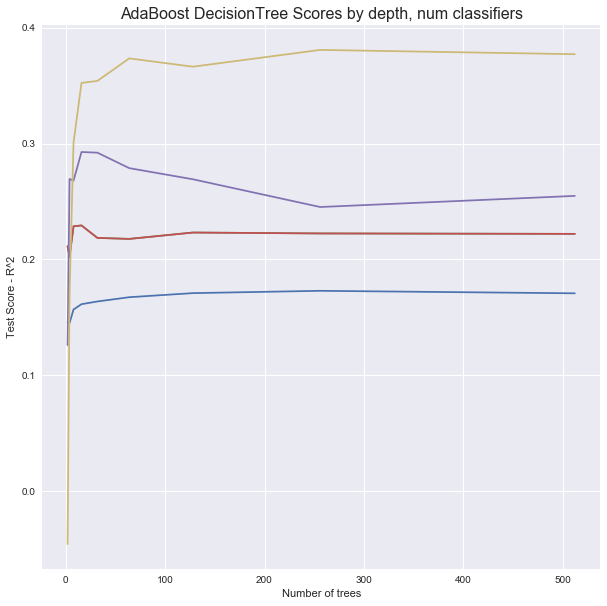

In [675]:
#
#  Fit a AdaBoost regression model using decision tree regressor
#
depths = [1, 2, 4, 10, None]
tree_nums = [2, 4, 8, 16, 32, 64, 128, 256, 512]

scores = []
for depth in depths:
    depth_scores = []
    for tree_num in tree_nums:
        dtc = DecisionTreeRegressor(max_depth=depth)
        ada = AdaBoostRegressor(dtc, learning_rate=0.05, n_estimators=tree_num)
        ada.fit(Xtrain, ytrain)
        depth_scores.append(ada.score(Xtest, ytest))
    scores.append(depth_scores)

plt.figure(figsize = (10, 10))
plt.title('AdaBoost DecisionTree Scores by depth, num classifiers', fontsize = 16)
plt.xlabel('Number of trees')
plt.ylabel('Test Score - R^2')
plt.plot(tree_nums, scores[0], label='depth 1')
plt.plot(tree_nums, scores[1], label='depth 2')
plt.plot(tree_nums, scores[1], label='depth 4')
plt.plot(tree_nums, scores[2], label='depth 10')
plt.plot(tree_nums, scores[3], label='Unlimited depth')
plt.show()

In [676]:
# Correlation heatmap
import seaborn as sns

#
#  We use Pandas' 'corr' method to compute pairwise correlation of column (defaults to Pearson)
#  Use which omits the unnormalized continuous predictors and the response variable
plt.figure(figsize = (15,15))
corr = df_spotify.corr() 

cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())